In [1]:
import os
import pandas as pd
import glob

# Emotion mapping
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Update this path to your extracted RAVDESS folder
data_dir = r"D:\ML PROJECTS\Emotion Detection from Voice\archive"

# Grab all .wav files
wav_files = glob.glob(os.path.join(data_dir, "Actor_*", "*.wav"))

# Extract metadata from filenames
data = []
for file in wav_files:
    parts = os.path.basename(file).split(".")[0].split('-')
    modality = parts[0]
    channel = parts[1]
    emotion = emotion_map[parts[2]]
    intensity = 'normal' if parts[3] == '01' else 'strong'
    statement = parts[4]
    repetition = parts[5]
    actor = int(parts[6])
    gender = 'male' if actor % 2 != 0 else 'female'

    data.append([file, emotion, intensity, actor, gender])

# Create DataFrame
df = pd.DataFrame(data, columns=["filepath", "emotion", "intensity", "actor", "gender"])

# Save metadata
df.to_csv("ravdess_metadata.csv", index=False)
print("✅ Metadata saved as ravdess_metadata.csv")


✅ Metadata saved as ravdess_metadata.csv


In [2]:
df.head()


,filepath,emotion,intensity,actor,gender
0,D:\ML PROJECTS\Emotion Detection from Voice\ar...,neutral,normal,1,male
1,D:\ML PROJECTS\Emotion Detection from Voice\ar...,neutral,normal,1,male
2,D:\ML PROJECTS\Emotion Detection from Voice\ar...,neutral,normal,1,male
3,D:\ML PROJECTS\Emotion Detection from Voice\ar...,neutral,normal,1,male
4,D:\ML PROJECTS\Emotion Detection from Voice\ar...,calm,normal,1,male


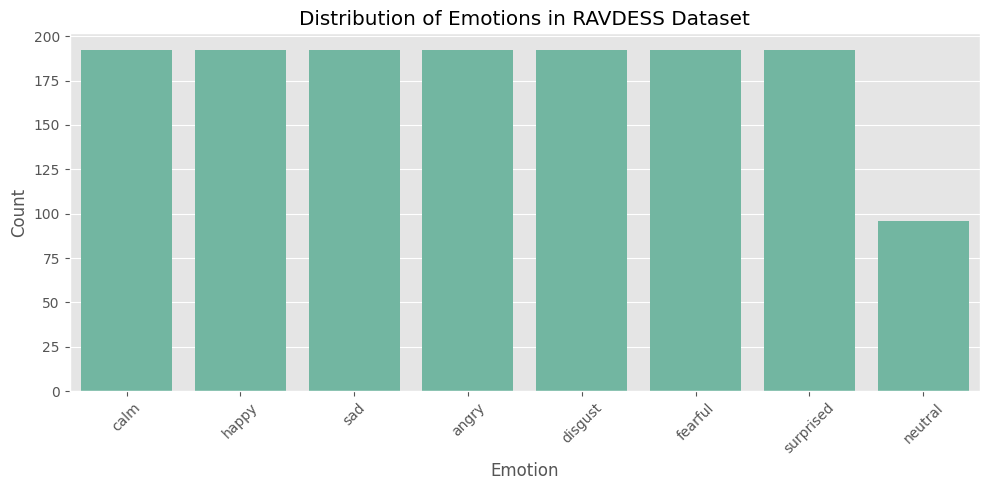

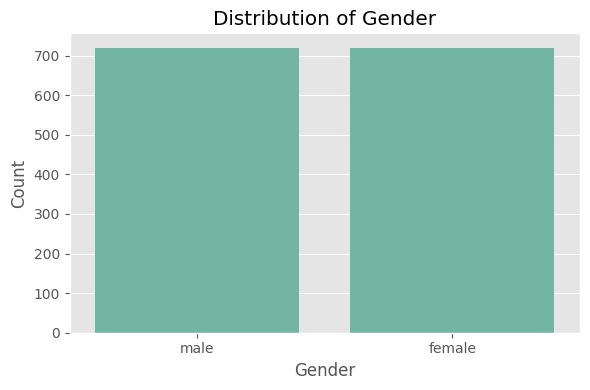

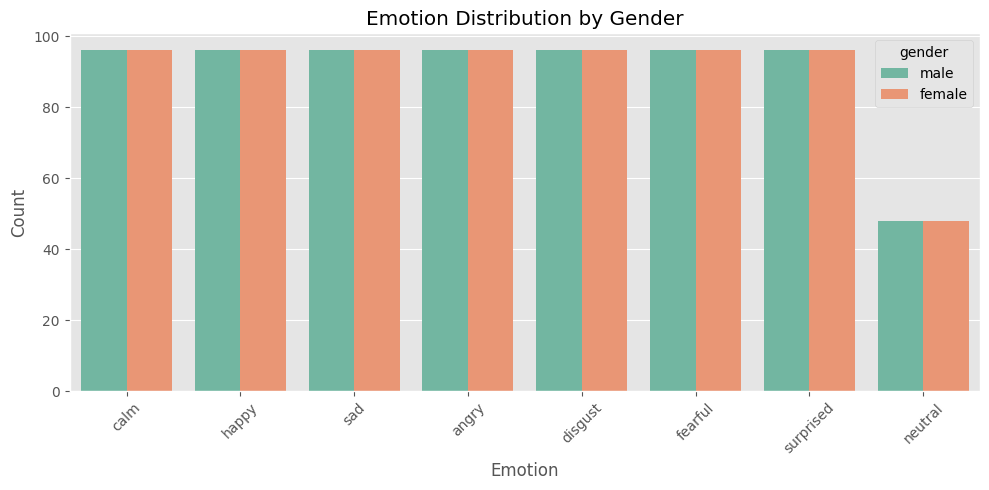

C:\Users\yuvan\AppData\Local\Temp\ipykernel_17240\2045075358.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='intensity', palette="pastel")


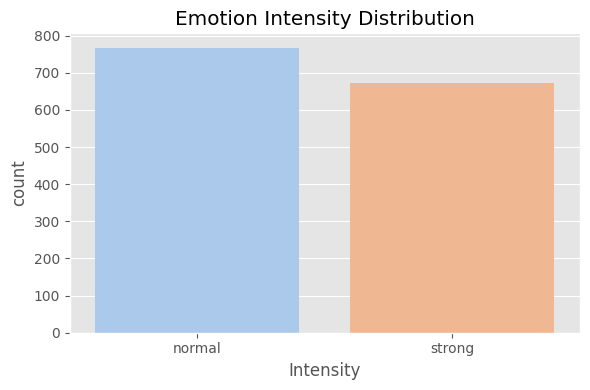

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the metadata
df = pd.read_csv(r"D:\ML PROJECTS\Emotion Detection from Voice\ravdess_metadata.csv")

# Optional: Use a known style or skip this line
plt.style.use("ggplot")  # <- safe built-in style
sns.set_palette("Set2")

# --- 1. Emotion Distribution ---
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
plt.title("Distribution of Emotions in RAVDESS Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 2. Gender Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender')
plt.title("Distribution of Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()

# --- 3. Emotion by Gender ---
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='emotion', hue='gender', order=df['emotion'].value_counts().index)
plt.title("Emotion Distribution by Gender")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 4. Intensity Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='intensity', palette="pastel")
plt.title("Emotion Intensity Distribution")
plt.xlabel("Intensity")
plt.tight_layout()
plt.show()


In [7]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# 🔹 Define the path to your extracted RAVDESS dataset
data_path = r"D:\ML PROJECTS\Emotion Detection from Voice\archive"

# 🔹 Emotion labels based on filename conventions
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# 🔹 Feature extraction function
def extract_features_from_path(dataset_path):
    features = []
    labels = []
    actors = []

    for actor_folder in tqdm(os.listdir(dataset_path)):
        actor_path = os.path.join(dataset_path, actor_folder)
        if not os.path.isdir(actor_path):
            continue
        
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                parts = file.split('-')
                emotion = emotion_dict.get(parts[2])
                actor_id = int(parts[-1].split('.')[0])
                gender = "female" if actor_id % 2 == 0 else "male"
                
                full_path = os.path.join(actor_path, file)
                try:
                    y, sr = librosa.load(full_path, duration=3, offset=0.5)
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                    mfccs_mean = np.mean(mfccs.T, axis=0)

                    features.append(mfccs_mean)
                    labels.append(emotion)
                    actors.append(gender)
                except Exception as e:
                    print(f"⚠️ Error processing {file}: {e}")
    
    return np.array(features), np.array(labels), np.array(actors)

# 🔹 Extract features and save them
features, labels, genders = extract_features_from_path(data_path)

np.save("X_features.npy", features)
np.save("y_labels.npy", labels)
np.save("genders.npy", genders)

print("✅ Features, labels, and genders saved as .npy files.")


100%|██████████| 25/25 [00:10<00:00,  2.32it/s]

✅ Features, labels, and genders saved as .npy files.


In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 🔹 Load saved files
X = np.load(r"D:\ML PROJECTS\Emotion Detection from Voice\X_features.npy")
y = np.load(r"D:\ML PROJECTS\Emotion Detection from Voice\y_labels.npy")
genders = np.load(r"D:\ML PROJECTS\Emotion Detection from Voice\genders.npy")

# 🔹 Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Optional: save label encoder for decoding later in frontend
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# 🔹 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("✅ Data loaded and split.")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


✅ Data loaded and split.
Training samples: 1152
Testing samples: 288


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

# 🔹 Train the model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 🔹 Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.2f}")
print(f"✅ F1 Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 🔹 Save the model
with open(r"D:\ML PROJECTS\Emotion Detection from Voice\emotion_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model saved to emotion_model.pkl")


✅ Accuracy: 0.60
✅ F1 Score: 0.60

Classification Report:
               precision    recall  f1-score   support

       angry       0.75      0.63      0.69        38
        calm       0.67      0.87      0.76        38
     disgust       0.54      0.71      0.61        38
     fearful       0.58      0.72      0.64        39
       happy       0.61      0.44      0.51        39
     neutral       0.50      0.32      0.39        19
         sad       0.51      0.47      0.49        38
   surprised       0.62      0.54      0.58        39

    accuracy                           0.60       288
   macro avg       0.60      0.59      0.58       288
weighted avg       0.60      0.60      0.60       288

✅ Model saved to emotion_model.pkl
